In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 2 a)

In [10]:
#create grid
n = 256
x = np.arange(n)
x[n//2:] = x[n//2:] - n
xx, yy = np.meshgrid(x, x)

#Remove singularity at origin
r = np.sqrt(xx**2 + yy**2)
r[0,0] = 1 

#Initial guess for potential
V = np.log(r)/(2*np.pi)

V[0,0] = 0.25 * (V[1,0] - V[-1,0] + V[0,1] + V[0,-1])

#Potential at the edges goes to zero
V = V - V[n//2, n//2]

V[0,0] = 4*V[1,0] - V[2,0] - V[1,1] - V[1,-1]


def avg(v):
    
    return 0.25 * (np.roll(v,1,0) + np.roll(v,-1,0) + np.roll(v,1,1) + np.roll(v,-1,1))

def get_rho(v):
    
    return v - avg(v)

rho = get_rho(V)

#We want rho[0,0] = V[0,0] = 1
V = V/rho[0,0]
V = V - V[0,0] + 1
rho = get_rho(V)

print("rho[0,0] is {}".format(rho[0,0]))
print("V[0,0] is {}".format(V[0,0]))
print("V[1,0] is {}".format(V[1,0]))
print("V[2,0] is {}".format(V[2,0]))
print("V[5,0] is {}".format(V[5,0]))

rho[0,0] is 1.0
V[0,0] is 1.0
V[1,0] is 0.0
V[2,0] is -0.5000000000000004
V[5,0] is -1.1609640474436813


So clearly, we get $V[1,0] = 0.00$ and $V[2,0] = -0.50$. As a sanity check, $V[5,0] = -1.16$, which is indeed around $-1.05$. 

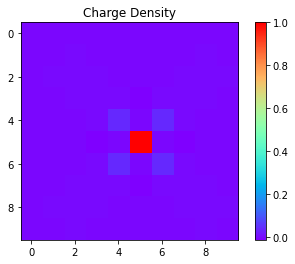

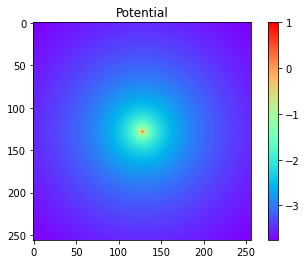

In [17]:
def wrap(p):
    
    return np.roll(p, p.shape[0]//2, axis = (0,1))

plt.figure(1)
plt.imshow(wrap(rho)[n//2 - 5: n//2 + 5, n//2 - 5: n//2 + 5], cmap = "rainbow")
plt.title("Charge Density")
plt.colorbar()
plt.show()

plt.figure(2)
plt.imshow(wrap(V), cmap = "rainbow")
plt.title("Potential")
plt.colorbar()
plt.show()

# Problem 2 b)

In [26]:
#Create grid
m = n//2
bc = np.zeros([m,m])
mask = np.zeros([m,m], dtype = "bool")

bc[0,:] = 0
bc[-1,:] = 0
bc[:,0] = 0
bc[:,-1] = 0

mask[0,:] = True
mask[-1,:] = True
mask[:,0] = True
mask[:,-1] = True

#Square box held at a potential of 1
bc[3*m//8:5*m//8, 3*m//8:5*m//8] = 1
mask[3*m//8:5*m//8, 3*m//8:5*m//8] = True

#Fourrier Transform of point charge potential
k = V.copy()
k_ft = np.fft.rfft2(k)


def V_ft(rho1, k_ft1, mask1, out = True):
    
    p_mat = np.zeros(mask1.shape)
    p_shape = p_mat.shape
    p_mat[mask1] = rho1

    # Compute potential by convoluting of k and rho
    p_mat = np.pad(p_mat, (0, p_mat.shape[0]))
    
    p_mat_ft = np.fft.rfftn(p_mat)
    V = np.fft.irfftn(p_mat_ft * k_ft1)
    
    V = V[:p_shape[0],:p_shape[1]]
    
    if out:
        
        return V[mask1]
    
    else:
        
        return V

    
def c_grad(V_mask, rho1, mask1, k_ft1, n_iter = 50):
    
    V_guess = V_ft(rho1, k_ft1, mask1)
    
    r = V_mask - V_guess
    p = r.copy()
    x = rho1.copy()
    r_sq = np.sum(r*r)
    
    for i in range(n_iter):
        
        A = V_ft(p, k_ft1, mask1)
        a = np.sum(r*r)/np.sum(A*p)
        x = x + a*p
        r = r - a*A
        new_r_sq = np.sum(r*r)
        b = new_r_sq/r_sq
        p = r + b*p
        r_sq = new_r_sq
    
    return x

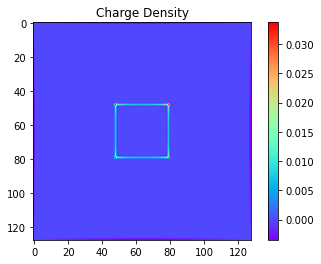

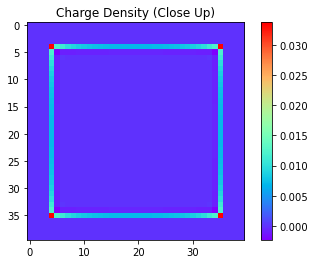

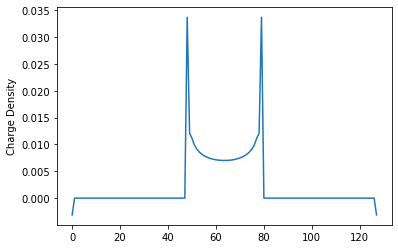

In [35]:
#Initial parameters
V_mask = bc[mask]
rho_i = 0*V_mask

#Conjugate gradient
rho_f = c_grad(V_mask, rho_i, mask, k_ft)
p_mat = np.zeros(mask.shape)
p_shape = p_mat.shape
p_mat[mask] = rho_f

plt.figure(1)
plt.imshow(p_mat, cmap = "rainbow")
plt.title("Charge Density")
plt.colorbar()
plt.show()

plt.figure(2)
plt.imshow(p_mat[m//2 - 20:m//2 + 20, m//2 - 20:m//2 + 20], cmap = "rainbow")
plt.title("Charge Density (Close Up)")
plt.colorbar()
plt.show()

p_side = p_mat[:,5*m//8-1]

plt.figure(3)
plt.plot(p_side)
plt.ylabel("Charge Density", c = "k")
plt.show()

## Problem 2 c)

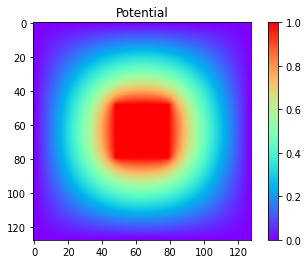

In [30]:
potential = V_ft(rho_f, k_ft, mask, out = False)

plt.figure(1)
plt.imshow(potential, cmap = "rainbow")
plt.title("Potential")
plt.colorbar()
plt.show()

In [37]:
#Inside the box
V_inside = potential[bc == 1]

print("The mean potential inside the box is {} with a std of {}".format(np.mean(V_inside), np.std(V_inside)))

The mean potential inside the box is 1.0000000624436807 with a std of 6.60342436069819e-07


So clearly, the potential is very close to constant inside the box.

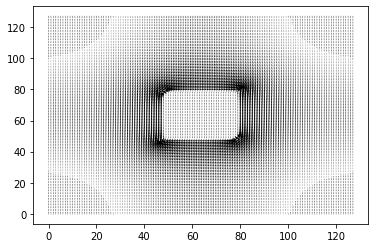

In [40]:
#Now, we want to find the electric field

dx, dy = np.gradient(potential)
Ex = -dx
Ey = -dy

x = np.arange(potential.shape[0])
X, Y = np.meshgrid(x,x)

plt.figure(1)
plt.quiver(X, Y, Ex, Ey)
plt.show()

This agrees with what I expect. Indeed, the field is perpendicular to any equipotential, and the field is stronger at corners.